In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)
import re
import emoji
import jieba
from gensim.models.word2vec import Word2Vec
from keras import regularizers
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, GRU, Dropout
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences
jieba.set_dictionary('./dict.txt.big') # 繁體字詞庫

Using TensorFlow backend.


In [ ]:
stopwords = [line.strip() for line in open("./stopword.txt", 'r', encoding='utf-8').readlines()]  
stopword=["ㄉ","呃","我","你","ㄟ"," ", "，", "。", "?", "!", "~", "！", "？", "=", "＝", "～", "「", "」", ",", ".", ">", "<", "/", "\\", "、", "^", "＾", "-","+","＋","B","1","2","3","4","5","6","7","8","9","0",".","...",":","ㄅ","ㄇ","ㄈ","X","D","(",")",":","－","』","『","@","＠","with","face","of","x","d","¬","_","ﾉ"]
#stopword+=stopwords
def preprocess(filepath):#讀檔   刪字   斷詞
    df=pd.read_csv(filepath,sep='\r')
    df=np.array(df)
    dfid=[]
    dfcomment=[]
    for i in range(len(df)):
        dfid.append(re.split(r',',df[i][0])[0])
        dfcomment.append(emoji.demojize(re.split(r',',df[i][0])[1]))
#     for i in range(len(dfcomment)) :
#         for j in range(len(stopword)):
#             #dfcomment[i]=dfcomment[i].replace(stopword[j],"")  
    seg_list=[]
    for i in range(len(dfcomment)):
        seg_list.append(list(jieba.cut(dfcomment[i],cut_all=False)))
    dfdic={"id":dfid,"comment":seg_list}
    dfd={"comment":seg_list}
    #print(len(dfid),len(seg_list))
    df=pd.DataFrame(dfd,columns=["comment"])     
    return df
def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df
def text_to_index(corpus):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            try:
                new_doc.append(word2idx[word])
            except:
                new_doc.append(0)
        new_corpus.append(new_doc)
    return np.array(new_corpus)

In [ ]:
X_train=preprocess("train_x.csv")
X_test=preprocess("test_x.csv")


Y_train=pd.read_csv("train_y.csv")
Y_train=Y_train.label
#Y_train = to_categorical(Y_train)

Building prefix dict from /home/jun-han-chen/ML2018FALL/hw4/dict.txt.big ...
Loading model from cache /tmp/jieba.u91c4c1c96858deb7b78a4f0191b1b37e.cache
Loading model cost 0.773 seconds.
Prefix dict has been built succesfully.


In [ ]:
corpus=pd.concat([X_train.comment,X_test.comment,X_test.comment,X_test.comment])
#corpus = np.vstack([X_train, X_test, X_test])
word_model = Word2Vec(corpus,size=256)
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print(vocab_size)
print(emdedding_size)
word_model.save('word2vec.model')
word_model = Word2Vec.load('word2vec.model')

In [ ]:
X_val=X_train[-10000:].comment
Y_val=Y_train[-10000:]
X_train=X_train[:-10000].comment
Y_train=Y_train[:-10000]

In [ ]:
embedding_matrix = np.zeros((len(word_model.wv.vocab.items()) + 1, word_model.vector_size))
word2idx={}
vocab_list = [(word, word_model.wv[word]) for word , _ in word_model.wv.vocab.items()]
for i, vocab in enumerate(vocab_list):
    word, vec = vocab
    embedding_matrix[i + 1] = vec
    word2idx[word] = i + 1
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1],
                            weights=[embedding_matrix],
                            trainable=False)
PADDING_LENGTH = 64
X_train = text_to_index(X_train)    
X_train = pad_sequences(X_train, maxlen=PADDING_LENGTH)    
X_val = text_to_index(X_val)
X_val = pad_sequences(X_val, maxlen=PADDING_LENGTH)
print("Shape:", X_train.shape)
print("Sample:", X_train[10])

In [ ]:
model = Sequential()
model.add(embedding_layer)
# model.add(LSTM(units=256,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))
# model.add(LSTM(units=256,dropout=0.5,recurrent_dropout=0.5,return_sequences=True))

model.add(GRU(units=128,activation="tanh",dropout=0.3,recurrent_dropout=0.3,return_sequences=True))
# model.add(GRU(units=32,activation="tanh",dropout=0.3,recurrent_dropout=0.3,return_sequences=True))
model.add(GRU(units=128,activation="tanh",dropout=0.3,recurrent_dropout=0.3,return_sequences=True))
model.add(GRU(units=128,activation="tanh",dropout=0.3,recurrent_dropout=0.3,return_sequences=False))


model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
sgd = SGD(lr=0.005, decay=0.00001, momentum=0.9)
adam = Adam(lr=0.001, decay=1e-6, clipvalue=0.5)

#model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])
model.summary()

In [ ]:
# Setting callback functions
csv_logger = CSVLogger('training.log')
checkpoint = ModelCheckpoint(filepath='models-keras/best',
                             verbose=1,
                             save_best_only=True,
                             monitor='val_acc',
                             mode='max')
earlystopping = EarlyStopping(monitor='val_acc', 
                              patience=6, 
                              verbose=1, 
                              mode='max')
                             
# Train the model
train_history = model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val),
          epochs=100,
          batch_size=500,
          callbacks=[earlystopping, checkpoint, csv_logger])

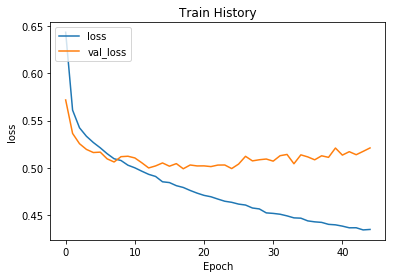

In [8]:
print(train_history)
#visualization
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(train_history.history['loss'])  
plt.plot(train_history.history['val_loss'])  
plt.title('Train History')  
plt.ylabel('loss')  
plt.xlabel('Epoch')  
plt.legend(['loss', 'val_loss'], loc='upper left')  
#plt.show() 

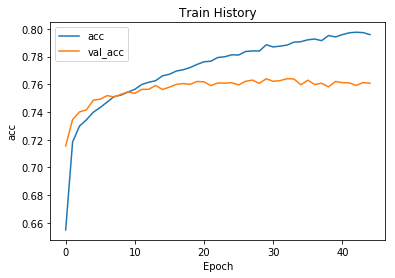

In [9]:
plt.plot(train_history.history['acc'])  
plt.plot(train_history.history['val_acc'])  
plt.title('Train History')  
plt.ylabel('acc')  
plt.xlabel('Epoch')  
plt.legend(['acc', 'val_acc'], loc='upper left') 

In [ ]:
model = load_model('./models-keras/best')
X_test=preprocess("test_x.csv")
X_test = text_to_index(X_test.comment)
X_test=pad_sequences(X_test, maxlen=PADDING_LENGTH)
Y_pred = model.predict(X_test)
th=0.5
for i in range(len(Y_pred)):
    if Y_pred[i]>th:
        Y_pred[i]=1
    else:
        Y_pred[i]=0
Y_pred=Y_pred.astype(int)
#Output
a=[]
for i in range(80000):
    a.append(str(i))
Id = pd.DataFrame(a,columns=["id"])
value = pd.DataFrame({"label":[0]*80000})
result = pd.concat([Id, value], axis=1)
result['label'] = Y_pred
result.to_csv('ans.csv', index=False, encoding='big5')

"在說別人白痴之前，先想想自己”
” 在說別人之前先想想自己，白痴”


In [10]:
import jieba
jieba.set_dictionary('dict.txt.big')
a=list(jieba.cut('在說別人白痴之前，先想想自己', cut_all=False))
b=list(jieba.cut('在說別人之前先想想自己，白痴', cut_all=False))
a

Building prefix dict from /home/jun-han-chen/ML2018FALL/hw4/dict.txt.big ...
Loading model from cache /tmp/jieba.u91c4c1c96858deb7b78a4f0191b1b37e.cache
Loading model cost 0.738 seconds.
Prefix dict has been built succesfully.


['在', '說', '別人', '白痴', '之前', '，', '先', '想想', '自己']

In [9]:
model = load_model('./models-keras/best')
a = text_to_index(a)
#a=pad_sequences(a, maxlen=5)
a
#model.predict(a)

array([list([0]), list([0]), list([0, 0]), list([0, 0]), list([0, 0]),
       list([0]), list([0]), list([0, 0]), list([0, 0])], dtype=object)

In [3]:
import pandas as pd
import numpy as np
import re
import emoji
import sys
import jieba
from gensim.models.word2vec import Word2Vec
from keras import regularizers
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, GRU, Dropout
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences
jieba.set_dictionary('dict.txt.big') # 繁體字詞庫
#stopwords = [line.strip() for line in open("./stopword.txt", 'r', encoding='utf-8').readlines()]  
stopword=["ㄉ","呃","我","你","ㄟ"," ", "，", "。", "?", "!", "~", "！", "？", "=", "＝", "～", "「", "」", ",", ".", ">", "<", "/", "\\", "、", "^", "＾", "-","+","＋","B","1","2","3","4","5","6","7","8","9","0",".","...",":","ㄅ","ㄇ","ㄈ","X","D","(",")",":","－","』","『","@","＠","with","face","of","x","d","¬","_","ﾉ"]
#stopword+=stopwords
def preprocess(filepath):#讀檔   刪字   斷詞
    df=pd.read_csv(filepath,sep='\r')
    df=np.array(df)
    dfid=[]
    dfcomment=[]
    for i in range(len(df)):
        dfid.append(re.split(r',',df[i][0])[0])
        dfcomment.append(emoji.demojize(re.split(r',',df[i][0])[1]))
#     for i in range(len(dfcomment)) :
#         for j in range(len(stopword)):
#             #dfcomment[i]=dfcomment[i].replace(stopword[j],"")  
    seg_list=[]
    for i in range(len(dfcomment)):
        seg_list.append(list(jieba.cut(dfcomment[i],cut_all=False)))
    dfdic={"id":dfid,"comment":seg_list}
    dfd={"comment":seg_list}
    #print(len(dfid),len(seg_list))
    df=pd.DataFrame(dfd,columns=["comment"])     
    return df

def text_to_index(corpus):
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            try:
                new_doc.append(word2idx[word])
            except:
                new_doc.append(0)
        new_corpus.append(new_doc)
    return np.array(new_corpus)
PADDING_LENGTH=64
model = load_model('best')
X_test=preprocess('test_x.csv')
X_test = text_to_index(X_test.comment)
X_test=pad_sequences(X_test, maxlen=PADDING_LENGTH)
Y_pred = model.predict(X_test,verbose=1)
th=0.5
for i in range(len(Y_pred)):
    if Y_pred[i]>th:
        Y_pred[i]=1
    else:
        Y_pred[i]=0
Y_pred=Y_pred.astype(int)
#Output
a=[]
for i in range(80000):
    a.append(str(i))
Id = pd.DataFrame(a,columns=["id"])
value = pd.DataFrame({"label":[0]*80000})
result = pd.concat([Id, value], axis=1)
result['label'] = Y_pred
result.to_csv('ans.csv', index=False, encoding='big5')

Building prefix dict from /home/jun-han-chen/ML2018FALL/hw4/dict.txt.big ...
Loading model from cache /tmp/jieba.u91c4c1c96858deb7b78a4f0191b1b37e.cache
Loading model cost 0.931 seconds.
Prefix dict has been built succesfully.


80000/80000 [==============================] - 63s 788us/step


In [4]:
Y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])